# Simple regression

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pystan
import scipy.stats as stats
import seaborn as sns
import tqdm
import sys
import ctypes
from IPython.display import display, clear_output, HTML
from numpy import trapz

sys.path.append('../')
from src.vimlts import VIMLTS

print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('Tensorflow version: ',tf.__version__, )

tfd=tfp.distributions

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Tensorflow version:  2.1.0


## Data generating process

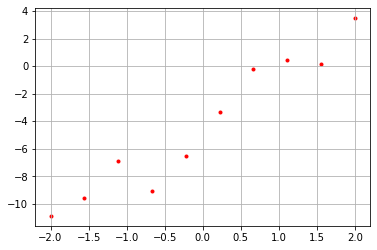

In [2]:
tf.random.set_seed(2)
num = 10

sigma=1
mu_a=3.5
mu_b=-4.

a=tfd.Normal(loc=mu_a,scale=sigma)
b=tfd.Normal(loc=mu_b,scale=sigma)


x = np.linspace(-2,2,num=num).reshape((num,1))
y = tfd.Normal(loc=(a.sample() * x[:,0] + b.sample()),scale=sigma).sample()
y=np.array(y).reshape([-1])
plt.scatter(x,y, marker='.', color='r')
plt.grid()
plt.show()
y.shape

X_test = np.linspace(-15, 15, 1000)

## Ground truth

In [3]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel(r'samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.9)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.9)
    plt.title(r'Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30,zorder=1, density=True); sns.kdeplot(param,color='g',zorder=2, shade=True, label=r'kde')
    plt.xlabel(param_name)
    plt.ylabel(r'density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label=r'mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label=r'median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.9, label=r'95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.9)

    plt.gcf().tight_layout()
    plt.legend()

In [4]:
stan_code = """
data{
  int<lower=0> N;
  real<lower=0> sigma;
  vector[N] y;
  vector[N] x;
  //For the prediced distribution
  int<lower=0> N2;
  vector[N2] x2;
}
parameters{
  real w1; //Instead of using e.g. half Gaussian
  real w0;
  //real sigma;
}
model{
  //y ~ normal(mu, sigma);
  y ~ normal(w1 * x + w0, sigma);
  w1 ~ normal(0, 1);
  w0 ~ normal(0, 1);
  //sigma ~ normal(0,10);
}
generated quantities {
  real Y_predict[N2];
  for (i in 1:N2){
    Y_predict = normal_rng(w1 * x2 + w0, sigma);
  }
}
"""

mcmc_model=pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_acccbce795de103a19c8833e3463a723 NOW.


In [5]:
mcmc_data = {'N': num,
        'sigma': sigma,
        'x': x[:,0],
        'y': y,
        'N2': X_test.shape[0],
        'x2': X_test}
fit=mcmc_model.sampling(data=mcmc_data,iter=2000,chains=4)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### MCMC posterior

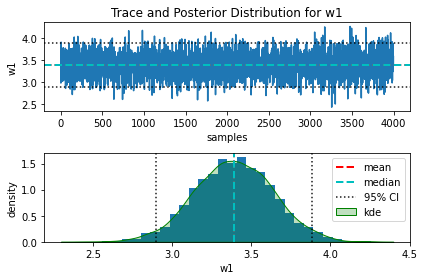

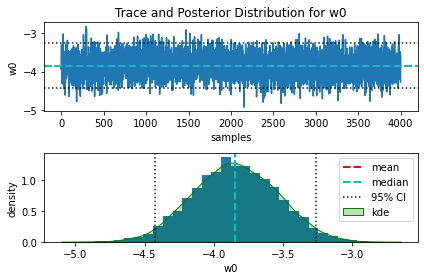

In [6]:
plt.figure()
plot_trace(fit.extract()['w1'],"w1")
plt.figure()
plot_trace(fit.extract()['w0'],"w0")

### MCMC PPD

In [7]:
samples_predictions=fit.extract()['Y_predict']; 
samples_predictions_mean=np.mean(samples_predictions,axis=0)
samples_predictions_2p5=np.quantile(samples_predictions,0.025,axis=0)
samples_predictions_97p5=np.quantile(samples_predictions,0.975,axis=0)
samples_predictions_50p0=np.quantile(samples_predictions,0.5,axis=0)

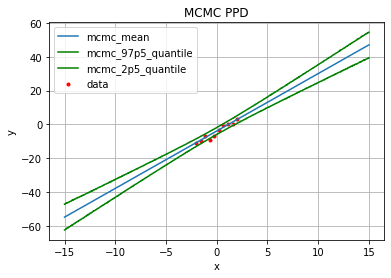

In [8]:
plt.plot(X_test,samples_predictions_mean,label=r"mcmc_mean")
plt.plot(X_test,samples_predictions_97p5,color='g',label=r"mcmc_97p5_quantile")
#plt.plot(X_test,samples_predictions_50p0,color='g',label="mcmc_50p0_quantile")
plt.plot(X_test,samples_predictions_2p5,color='g',label=r"mcmc_2p5_quantile")
plt.scatter(x,y, marker='.', color='r', label=r"data")
plt.legend()
plt.grid()
plt.xlabel(r"x")
plt.ylabel(r"y");
plt.title(r"MCMC PPD");

## MFVI

### Functions

In [9]:
# Convenience function to write out weights
class Logger:
    """
        Writes out the weights, gradient, and losses.
    """  
    def __init__(self, steps, num_weights = 4):
        self.steps = steps
        self.num_weights = num_weights
        self.X = np.zeros((steps,(4+2*num_weights)))
        
    def log(self, step, epoch, lambda_tunable, lambda_tunable_grad, loss, loss_kl, loss_nll):
        n = self.num_weights
        self.X[step,0] = epoch
        self.X[step,1:(n+1)] = lambda_tunable.numpy()
        self.X[step,(n+1):((2*n)+1)] = lambda_tunable_grad.numpy()
        self.X[step,((2*n)+1)] = loss.numpy()
        self.X[step,((2*n)+2)] = loss_kl.numpy()
        self.X[step,((2*n)+3)] = loss_nll.numpy()
        
    def getX(self):
        return self.X

In [10]:
def kl_divergence(q, p):
    """
        Calculates the kl divergence.
    """
    # Avoid numerical problems
    mask = ((q > 1e-08) | (p > 1e-08)) & (np.isinf(q)==0) & (np.isinf(p)==0)
    return tf.math.reduce_sum(tf.where(mask, q*tf.math.log(q/p), 0))

### Create a model

In [11]:
# Number of epochs
epochs=160

# Learning rate
lr = 0.001

# Variational parameters init - weigth w1 
a_init_w1=(0.1,)
b_init_w1=(-0.5,)
delta_theta_init_w1 = (-10,6.,7.,10.)  
alpha_init_w1 = (0.1,)
beta_init_w1 = (0,)

# Variational parameters init - weigth w0
a_init_w0=(0.1,)
b_init_w0=(-0.5,)
delta_theta_init_w0 =(-10,6.,7.,10.)  
alpha_init_w0 = (0.1,)
beta_init_w0 = (0.,)

# Variational parameters init
lambda_init_w1=a_init_w1+b_init_w1+delta_theta_init_w1+alpha_init_w1+beta_init_w1
lambda_init_w0=a_init_w0+b_init_w0+delta_theta_init_w0+alpha_init_w0+beta_init_w0
lambda_init=lambda_init_w1+lambda_init_w0

num_lambda=np.shape(lambda_init)[0]
num_lambda_per_dist=np.shape(lambda_init_w1)[0]
lambda_tunable = tf.Variable(lambda_init,dtype='float32') 

# Instance of a variational distribution as VIMLTS
q_dist_w1=VIMLTS(np.shape(delta_theta_init_w1)[0])
q_dist_w0=VIMLTS(np.shape(delta_theta_init_w0)[0])

# List to save the variational distribution during training
q_w1_dist_history=[]
q_w0_dist_history=[]

# Prior
prior_dist=tfd.Normal(loc=0.,scale=1.)

# Logging
logger = Logger(epochs,num_weights=num_lambda)

ytensor = y.reshape([len(y),1])

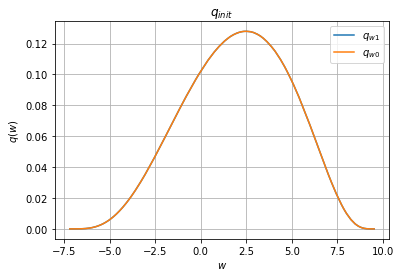

In [12]:
# Update the variational parameter to the variational distribution
lambda_tunable_w1=lambda_tunable[0*num_lambda_per_dist:(0*num_lambda_per_dist+num_lambda_per_dist)]
lambda_tunable_w0=lambda_tunable[1*num_lambda_per_dist:(1*num_lambda_per_dist+num_lambda_per_dist)]

q_dist_w1.update_lambda_param(lambda_tunable_w1)
q_dist_w0.update_lambda_param(lambda_tunable_w0)

# Save the distribution to the history
q_w1_dist_history.append(q_dist_w1.get_target_dist())
q_w0_dist_history.append(q_dist_w0.get_target_dist())


plt.plot(q_w1_dist_history[0][1],q_w1_dist_history[0][0],label=r"$q_{w1}$")
plt.plot(q_w0_dist_history[0][1],q_w0_dist_history[0][0],label=r"$q_{w0}$")
plt.legend()
plt.grid()
plt.ylabel(r"$q(w)$")
plt.xlabel(r"$w$")
plt.title(r'$q_{init}$');

In [13]:
for i in tqdm.tqdm(range(epochs)):
    with tf.GradientTape() as tape:  
        tape.watch([lambda_tunable])

        # Parameter update --------------------------------------------------
        # Parameter w1
        lambda_tunable_w1=lambda_tunable[0*num_lambda_per_dist:(0*num_lambda_per_dist+num_lambda_per_dist)]
        
        # Parameter w0
        lambda_tunable_w0=lambda_tunable[1*num_lambda_per_dist:(1*num_lambda_per_dist+num_lambda_per_dist)]

        q_dist_w1.update_lambda_param(lambda_tunable_w1)
        q_dist_w0.update_lambda_param(lambda_tunable_w0)

        # l_nll ------------------------------------------
        z_sample_w1,w1=q_dist_w1.get_sample_w()
        z_sample_w0,w0=q_dist_w0.get_sample_w()

        # Likelihood
        y_prob = tfd.Normal(loc=x*w1+w0, scale=sigma)
        # loss_nll
        l_nll = -tf.reduce_sum(y_prob.log_prob(ytensor))

        # l_kl ------------------------------------------      
        variational_dist_sample_w1=q_dist_w1.get_target_dist_for_z(z_sample_w1)
        prior_sample=prior_dist.prob(w1)
        l_kl_w1=kl_divergence(variational_dist_sample_w1,prior_sample)

        variational_dist_sample_w0=q_dist_w0.get_target_dist_for_z(z_sample_w0)
        prior_sample=prior_dist.prob(w0)
        l_kl_w0=kl_divergence(variational_dist_sample_w0,prior_sample)


        l_kl=l_kl_w1+l_kl_w0

        # loss --------------------------------------
        loss = l_nll + l_kl

    grads = tape.gradient(loss,lambda_tunable)
    
    # Check for NaNs in gradient
    if True in tf.math.is_nan(grads):
        print("+++++++++NaN in gradient+++++++++++++")
        print("Parameter:", w_sample.numpy())
        print("Grads:",grads)
        continue

    # Save epoche to logger
    logger.log(i, i, lambda_tunable, grads, loss, l_kl, l_nll)    

    # Update the variational parameter
    lambda_tunable = tf.Variable(lambda_tunable - lr*grads)
    

    # Prints and history
    if i % 10 == 0 or i < 10 or i==epochs-1:
        clear_output()
        print("\tloss \t", loss.numpy(),"\tl_nll\t",l_nll.numpy(),"\tl_kl\t",l_kl.numpy(), "\tlr ", lr)
        save_history=True
        if(save_history):
            q_w1_dist_history.append(q_dist_w1.get_target_dist())
            q_w0_dist_history.append(q_dist_w0.get_target_dist())


100%|██████████| 160/160 [00:06<00:00, 26.32it/s]	loss 	 30.507187 	l_nll	 22.971035 	l_kl	 7.536151 	lr  0.001



### Analyse the run

#### Compare the VIMLTS solution to the ground truth

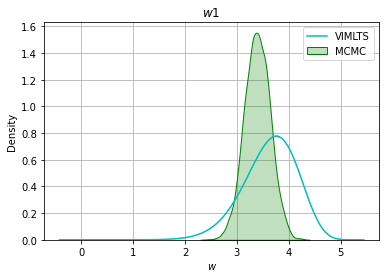

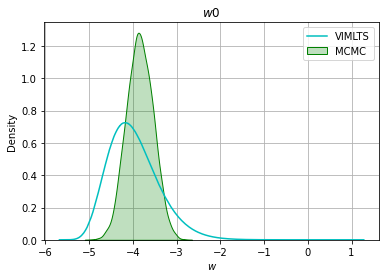

In [14]:
length_history=np.shape(q_w0_dist_history)[0]

plt.plot(q_w1_dist_history[length_history-1][1],q_w1_dist_history[length_history-1][0],'c',label="VIMLTS")
sns.kdeplot(fit.extract()['w1'],color='g',zorder=2, shade=True, label="MCMC")
plt.legend()
plt.grid()
plt.ylabel(r"Density")
plt.xlabel(r"$w$")
plt.title(r'$w1$');

plt.figure()

plt.plot(q_w0_dist_history[length_history-1][1],q_w0_dist_history[length_history-1][0],'c',label="VIMLTS")
sns.kdeplot(fit.extract()['w0'],color='g',zorder=2, shade=True, label="MCMC")
plt.legend()
plt.grid()
plt.ylabel(r"Density")
plt.xlabel(r"$w$")
plt.title(r'$w0$');

#### Analyse the loss

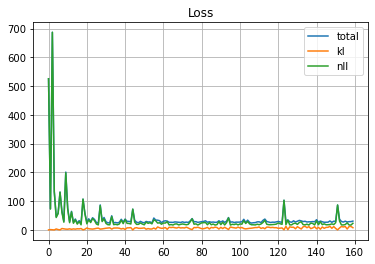

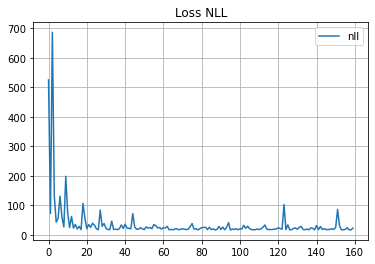

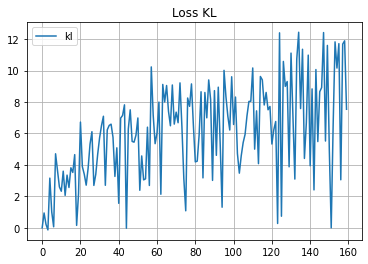

nll:	 22.97103500366211
kl:	 11.888823509216309
total:	 30.507186889648438


In [15]:
W = logger.getX()
loss_history = W[:,W.shape[1]-3]
loss_history_nll = W[:,W.shape[1]-1]
loss_history_kl = W[:,W.shape[1]-2]

plt.plot(loss_history,label=r"total")
plt.plot(loss_history_kl,label=r"kl")
plt.plot(loss_history_nll,label=r"nll")
plt.legend()
plt.grid()
plt.title(r"Loss")
plt.show()

plt.figure()
plt.plot(loss_history_nll,label=r"nll")
plt.legend()
plt.grid()
plt.title(r"Loss NLL")
plt.show()


plt.figure()
plt.plot(loss_history_kl,label=r"kl")
plt.legend()
plt.grid()
plt.title(r"Loss KL")
plt.show()

print("nll:\t",W[W.shape[0]-1,W.shape[1]-1])
print("kl:\t",W[W.shape[0]-2,W.shape[1]-2])
print("total:\t",W[W.shape[0]-1,W.shape[1]-3])

#### Show the posteriors

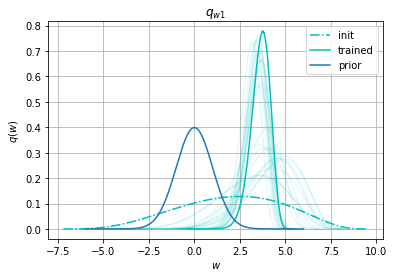

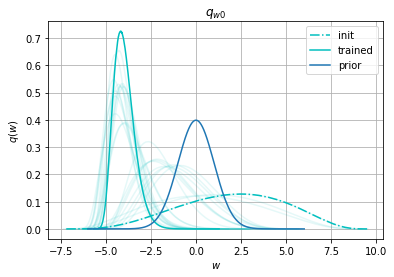

In [16]:
ww=np.linspace(-6,6,1000)
prior=prior_dist.prob(ww)

length_history=np.shape(q_w1_dist_history)[0]

plt.plot(q_w1_dist_history[0][1],q_w1_dist_history[0][0],'c-.',label=r"init")
for i in range(1,length_history-2):
    plt.plot(q_w1_dist_history[i][1],q_w1_dist_history[i][0],'c',alpha=0.1)
plt.plot(q_w1_dist_history[length_history-1][1],q_w1_dist_history[length_history-1][0],'c',label=r"trained")
plt.plot(ww,prior,label=r"prior")

plt.legend()
plt.grid()
plt.ylabel(r"$q(w)$")
plt.xlabel(r"$w$")
plt.title(r'$q_{w1}$');


plt.figure()
plt.plot(q_w0_dist_history[0][1],q_w0_dist_history[0][0],'c-.',label=r"init")
for i in range(1,length_history-2):
    plt.plot(q_w0_dist_history[i][1],q_w0_dist_history[i][0],'c',alpha=0.1)
plt.plot(q_w0_dist_history[length_history-1][1],q_w0_dist_history[length_history-1][0],'c',label=r"trained")
plt.plot(ww,prior,label=r"prior")

plt.legend()
plt.grid()
plt.ylabel(r"$q(w)$")
plt.xlabel(r"$w$")
plt.title(r'$q_{w0}$');

#### Show history of the variational distribution.

In [17]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def print_variational_w1_dist(i):
    plt.plot(q_w1_dist_history[i][1],q_w1_dist_history[i][0],'c')
    plt.plot(ww,prior,label="priorDist")
    plt.grid()
    return

def print_variational_w0_dist(i):
    plt.plot(q_w0_dist_history[i][1],q_w0_dist_history[i][0],'c')
    plt.plot(ww,prior,label="priorDist")
    plt.grid()
    return

In [18]:
interact(print_variational_w1_dist, i=widgets.IntSlider(min=0, max=np.shape(q_w1_dist_history)[0]-2, step=1, value=10));
interact(print_variational_w0_dist, i=widgets.IntSlider(min=0, max=np.shape(q_w0_dist_history)[0]-2, step=1, value=10));

interactive(children=(IntSlider(value=10, description='i', max=25), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=10, description='i', max=25), Output()), _dom_classes=('widget-interact'…

## Predictive

w1 tf.Tensor([3.9017308], shape=(1,), dtype=float32)
w0 tf.Tensor([-3.2663305], shape=(1,), dtype=float32)


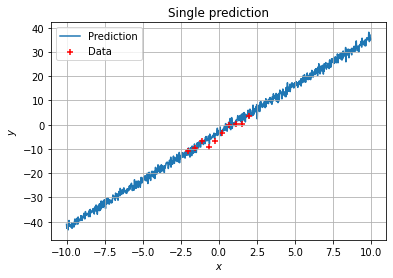

In [19]:
z_sample_w1,w1=q_dist_w1.get_sample_w()
z_sample_w0,w0=q_dist_w0.get_sample_w()
print("w1",w1)
print("w0",w0)
xx=np.linspace(-10, 10, 1000)
y_prob = tfd.Normal(loc=xx*w1+w0, scale=sigma)
plt.plot(xx,y_prob.sample(),zorder=0, label=r'Prediction')
plt.scatter(x, y, marker='+',c='r',zorder=1, label=r'Data')
plt.grid()
plt.legend()
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.title(r'Single prediction');

In [20]:
num_predictions=1000
y_pred_list = []
list_w1=[]
list_w0=[]

# Iterate over number of predictions
for i in tqdm.tqdm(range(num_predictions)):
    z_sample_w1,w1=q_dist_w1.get_sample_w()
    z_sample_w0,w0=q_dist_w0.get_sample_w()
    list_w1.append(w1.numpy())
    list_w0.append(w0.numpy())
    y_prob = tfd.Normal(loc=X_test*w1+w0, scale=sigma)
    y_pred = y_prob.sample()
    y_pred = y_pred.numpy().reshape(-1,1)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_predictions_mean=np.mean(y_preds,axis=1)
y_predictions_2p5=np.quantile(y_preds,0.025,axis=1)
y_predictions_97p5=np.quantile(y_preds,0.975,axis=1)
y_predictions_50p0=np.quantile(y_preds,0.5,axis=1)
y_predictions_mean.shape

100%|██████████| 1000/1000 [00:05<00:00, 175.93it/s]


(1000,)

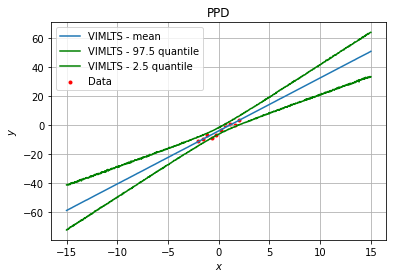

In [21]:
plt.plot(X_test,y_predictions_mean,label="VIMLTS - mean")
plt.plot(X_test,y_predictions_97p5,color='g',label="VIMLTS - 97.5 quantile")
#plt.plot(X_test,y_predictions_50p0,color='g',label="vimlt_50p0_quantile")
plt.plot(X_test,y_predictions_2p5,color='g',label="VIMLTS - 2.5 quantile")
plt.scatter(x,y, marker='.', color='r', label="Data")
plt.legend()
plt.grid()
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.title(r'PPD');